
# Spatial Declustering in Python for Engineers and Geoscientists 
### Michael Pyrcz, Associate Professor, University of Texas at Austin 

#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

This is a tutorial for / demonstration of **spatial declustering in Python with simple wrappers and reimplementations of GSLIB: Geostatistical Library methods** (Deutsch and Journel, 1997). Almost every spatial dataset is based on biased sampling.  This includes clustering (increased density of samples) over specific ranges of values.  For example, more samples in an area of high feature values.  Spatial declustering is a process of assigning data weights based on local data density.  The cell-based declustering approach (Deutsch and Journel, 1997; Pyrcz and Deutsch, 2014; Pyrcz and Deutsch, 2003, paper is available here: http://gaa.org.au/pdf/DeclusterDebias-CCG.pdf) is based on the use of a mesh over the area of interest.  Each datum's weight is inverse to the number of data in each cell.  Cell offsets of applied to smooth out influence of mesh origin.  Multiple cell sizes are applied and typically the cell size that minimizes the declustered distribution mean is applied for preferential sampling in the high-valued locations (the maximizing cell size is applied if the data is preferential sampled in the low-valued locations).  If there is a nominal data spacing with local clusters, then this spacing is the best cell size.

This exercise demonstrates the cell-based declustering approach in Python with wrappers and reimplimentation of GSLIB methods.  The steps include:

1. generate a 2D sequential Guassian simulation using a wrapper of GSLIB's sgsim method
2. apply regular sampling to the 2D realization
3. preferentially removing samples in the low-valued locations
4. calculate cell-based declustering weights 
5. visualize the location map of the declustering weights and the original exhaustive, sample and the new declustered distributions.

To accomplish this I have provide wrappers or reimplementation in Python for the following GSLIB methods:

1. sgsim - sequantial Gaussian simulation limited to 2D and unconditional
2. hist - histograms plots reimplemented with GSLIB parameters using python methods
3. locmap - location maps reimplemented with GSLIB parameters using python methods
4. pixelplt - pixel plots reimplemented with GSLIB parameters using python methods
5. locpix - my modification of GSLIB to superimpose a location map on a pixel plot reimplemented with GSLIB parameters using Python methods
5. affine - affine correction adjust the mean and standard deviation of a feature reimplemented with GSLIB parameters using Python methods

These methods are all in the functions declared upfront. To run this demo all one has to do is download and place in your working directory the following executables from the GSLIB/bin directory:

1. sgsim.exe
2. declus.exe
3. nscore.exe (not currently used in demo, but wrapper is included)

The GSLIB source and executables are available at http://www.statios.com/Quick/gslib.html.  For the reference on using GSLIB check out the User Guide, GSLIB: Geostatistical Software Library and User's Guide by Clayton V. Deutsch and Andre G. Journel.

I did this to allow people to use these GSLIB functions that are extremely robust in Python. Also this should be a bridge to allow so many familar with GSLIB to work in Python as a kept the parameterization and displays consistent with GSLIB.  The wrappers are simple functions declared below that write the parameter files, run the GSLIB executable in the working directory and load and visualize the output in Python. This will be included on GitHub for anyone to try it out https://github.com/GeostatsGuy/.  

I used this tutorial in my Introduction to Geostatistics undergraduate class (PGE337 at UT Austin) as part of a first introduction to geostatistics and Python for the engineering undergraduate students. It is assumed that students have no previous Python, geostatistics nor machine learning experience; therefore, all steps of the code and workflow are explored and described. This tutorial is augmented with course notes in my class.  The Python code and markdown was developed and tested in Jupyter. 

#### Load the required libraries

The following code loads the required libraries.


In [3]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

Here are the wrappers and reimplementations of GSLIB method along with two utilities to load GSLIB's Geo-EAS from data files into DataFrames and 2D Numpy arrays.

In [11]:
# Some GeostatsPy Functions - by Michael Pyrcz, maintained at https://git.io/fNgR7.
# A set of functions to provide access to GSLIB in Python.
# GSLIB executables: nscore.exe, declus.exe, gam.exe, gamv.exe, vmodel.exe, kb2d.exe & sgsim.exe must be in the working directory 
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt                          
import random as rand
image_type = 'tif'; dpi = 600

# utility to convert GSLIB Geo-EAS files to a 1D or 2D numpy ndarray for use with Python methods
def GSLIB2ndarray(data_file,kcol,nx,ny): 
    colArray = []
    if ny > 1:
        array = np.ndarray(shape=(ny,nx),dtype=float,order='F')
    else:
        array = np.zeros(nx)    
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          # get the number of columns
        for icol in range(0, ncol):   # read over the column names
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]       
        if ny > 1:
            for iy in range(0,ny):
                for ix in range(0,nx):
                    head = [next(myfile) for x in range(1)]
                    array[ny-1-iy][ix] = head[0].split()[kcol]
        else:
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ix] = head[0].split()[kcol]
    return array,col_name 

# utility to convert GSLIB Geo-EAS files to a pandas DataFrame for use with Python methods
def GSLIB2Dataframe(data_file):
    colArray = []
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])
        for icol in range(0, ncol):
            head = [next(myfile) for x in range(1)]
            colArray.append(head[0].split()[0])
        data = np.loadtxt(myfile, skiprows = 0)
        df = pd.DataFrame(data)
        df.columns = colArray
        return df

# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods, displayed and as image file
def hist(array,xmin,xmax,log,cumul,bins,weights,xlabel,title,fig_name):
    plt.figure(figsize=(8,6))
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency')  
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return
   
# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods
def pixelplt(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    plt.figure(figsize=(8,6))
    im = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels=np.linspace(vmin,vmax,100))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im,orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return im

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods
def locmap(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    ixy = 0 
    plt.figure(figsize=(8,6))    
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return im

# pixel plot and location map, reimplementation in Python of a GSLIB MOD with MatPlotLib methods
def locpix(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap,fig_name):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    plt.figure(figsize=(8,6))
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax,levels = np.linspace(vmin,vmax,100))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)  
    cbar = plt.colorbar(orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return cs

# affine distribution correction reimplemented in Python with numpy methods 
def affine(array,tmean,tstdev):    
    if array.ndim != 2:
        Print("Error: must use a 2D array")
        return
    nx = array.shape[0]
    ny = array.shape[1]
    mean = np.average(array)
    stdev = np.std(array)
    for iy in range(0,ny):
        for ix in range(0,nx):
             array[ix,iy]= (tstdev/stdev)*(array[ix,iy] - mean) + tmean  
    return(array)            

# normal score transform, wrapper for nscore from GSLIB (.exe must be in working directory)(not used in this demo)   
def nscore(x):
    import os
    import numpy as np
    file = 'nscore_out.dat'
    nx = np.ma.size(x); ny = 1
    ndarray2GSLIB(x,"nscore.dat","value")
    file = open("nscore.par", "w")
    file.write("                  Parameters for NSCORE                                    \n")
    file.write("                  *********************                                    \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("nscore.dat           -file with data                                       \n")
    file.write("1   0                    -  columns for variable and weight                \n")
    file.write("-1.0e21   1.0e21         -  trimming limits                                \n")
    file.write("0                        -1=transform according to specified ref. dist.    \n")
    file.write("../histsmth/histsmth.out -  file with reference dist.                      \n")
    file.write("1   2                    -  columns for variable and weight                \n")
    file.write("nscore.out               -file for output                                  \n")
    file.write("nscore.trn               -file for output transformation table             \n")
    file.close()
    
    os.system('nscore.exe nscore.par')
    file_in = 'nscore.out'
    y,name = GSLIB2ndarray('nscore.out',1,nx,ny)
    return(y)

# cell-based declustering, 2D wrapper for declus from GSLIB (.exe must be in working directory)
def declus(df,xcol,ycol,vcol,cmin,cmax,cnum,bmin):
    import os
    import numpy as np
    nrow = len(df)
    weights = []
    file = 'declus_out.dat'
    file_out = open(file, "w")
    file_out.write('declus_out.dat' + '\n')  
    file_out.write('3' + '\n')  
    file_out.write('x' + '\n') 
    file_out.write('y' + '\n')
    file_out.write('value' + '\n')  
    for irow in range(0, nrow):
        file_out.write(str(df.iloc[irow][xcol])+' '+str(df.iloc[irow][ycol])+' '+str(df.iloc[irow][vcol])+' \n')        
    file_out.close()
    
    file = open("declus.par", "w")
    file.write("                  Parameters for DECLUS                                    \n")
    file.write("                  *********************                                    \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("declus_out.dat           -file with data                                   \n")
    file.write("1   2   0   3               -  columns for X, Y, Z, and variable           \n")
    file.write("-1.0e21     1.0e21          -  trimming limits                             \n")
    file.write("declus.sum                  -file for summary output                       \n") 
    file.write("declus.out                  -file for output with data & weights           \n")
    file.write("1.0   1.0                   -Y and Z cell anisotropy (Ysize=size*Yanis)    \n") 
    file.write(str(bmin) + "                -0=look for minimum declustered mean (1=max)   \n") 
    file.write(str(cnum) + " " + str(cmin) + " " + str(cmax) + " -number of cell sizes, min size, max size      \n")
    file.write("5                           -number of origin offsets                      \n")
    file.close()
    
    os.system('declus.exe declus.par')
    df = GSLIB2Dataframe("declus.out")
    for irow in range(0, nrow):
        weights.append(df.iloc[irow,3])    

    return(weights) 
 
def make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2=1,cc2=0,azi2=0,hmaj2=0,hmin2=0):
    if cc2 == 0:
        nst = 1
    var = dict([('nug', nug), ('nst', nst), ('it1', it1),('cc1', cc1),('azi1', azi1),('hmaj1', hmaj1), ('hmin1', hmin1), 
      ('it2', it2),('cc2', cc2),('azi2', azi2),('hmaj2', hmaj2), ('hmin2', hmin2)])
    if nug + cc1 + cc2 != 1:
        print('\x1b[0;30;41m make_variogram Warning: sill does not sum to 1.0, do not use in simulation \x1b[0m')
    if cc1 < 0 or cc2 < 0 or nug < 0 or hmaj1 < 0 or hmaj2 < 0 or hmin1 < 0 or hmin2 < 0:
        print('\x1b[0;30;41m make_variogram Warning: contributions and ranges must be all positive \x1b[0m')
    if hmaj1 < hmin1 or hmaj2 < hmin2:
        print('\x1b[0;30;41m make_variogram Warning: major range should be greater than minor range \x1b[0m')
    return var
    
# sequential Gaussian simulation, 2D unconditional wrapper for sgsim from GSLIB (.exe must be in working directory)
def GSLIB_sgsim_2d_uncond(nreal,nx,ny,hsiz,seed,var,output_file):
    import os
    import numpy as np 
    
    nug = var['nug']
    nst = var['nst']; it1 = var['it1']; cc1 = var['cc1']; azi1 = var['azi1']; hmaj1 = var['hmaj1']; hmin1 = var['hmin1'] 
    it2 = var['it2']; cc2 = var['cc2']; azi2 = var['azi2']; hmaj2 = var['hmaj2']; hmin2 = var['hmin2']     
    max_range = max(hmaj1,hmaj2) 
    hmn = hsiz * 0.5   
    hctab = int(max_range/hsiz)*2 + 1
    
    sim_array = np.random.rand(nx,ny)
  
    file = open("sgsim.par", "w")
    file.write("              Parameters for SGSIM                                         \n")
    file.write("              ********************                                         \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETER:                                                        \n")
    file.write("none                          -file with data                              \n")
    file.write("1  2  0  3  5  0              -  columns for X,Y,Z,vr,wt,sec.var.          \n")
    file.write("-1.0e21 1.0e21                -  trimming limits                           \n")
    file.write("0                             -transform the data (0=no, 1=yes)            \n")
    file.write("none.trn                      -  file for output trans table               \n")
    file.write("1                             -  consider ref. dist (0=no, 1=yes)          \n")
    file.write("none.dat                      -  file with ref. dist distribution          \n")
    file.write("1  0                          -  columns for vr and wt                     \n")
    file.write("-4.0    4.0                   -  zmin,zmax(tail extrapolation)             \n")
    file.write("1      -4.0                   -  lower tail option, parameter              \n")
    file.write("1       4.0                   -  upper tail option, parameter              \n")
    file.write("0                             -debugging level: 0,1,2,3                    \n")
    file.write("nonw.dbg                      -file for debugging output                   \n")
    file.write(str(output_file) + "           -file for simulation output                  \n")
    file.write(str(nreal) + "                 -number of realizations to generate          \n")
    file.write(str(nx) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write(str(ny) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write("1 0.0 1.0                     - nz zmn zsiz                                \n")
    file.write(str(seed) + "                  -random number seed                          \n")
    file.write("0     8                       -min and max original data for sim           \n")
    file.write("12                            -number of simulated nodes to use            \n")
    file.write("0                             -assign data to nodes (0=no, 1=yes)          \n")
    file.write("1     3                       -multiple grid search (0=no, 1=yes),num      \n")
    file.write("0                             -maximum data per octant (0=not used)        \n")
    file.write(str(max_range) + " " + str(max_range) + " 1.0 -maximum search  (hmax,hmin,vert) \n")
    file.write(str(azi1) + "   0.0   0.0       -angles for search ellipsoid                 \n")
    file.write(str(hctab) + " " + str(hctab) + " 1 -size of covariance lookup table        \n")
    file.write("0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC        \n")
    file.write("none.dat                      -  file with LVM, EXDR, or COLC variable     \n")
    file.write("4                             -  column for secondary variable             \n")
    file.write(str(nst) + " " + str(nug) + "  -nst, nugget effect                          \n")
    file.write(str(it1) + " " + str(cc1) + " " +str(azi1) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
    file.write(" " + str(hmaj1) + " " + str(hmin1) + " 1.0 - a_hmax, a_hmin, a_vert        \n")
    file.write(str(it2) + " " + str(cc2) + " " +str(azi2) + " 0.0 0.0 -it,cc,ang1,ang2,ang3\n")
    file.write(" " + str(hmaj2) + " " + str(hmin2) + " 1.0 - a_hmax, a_hmin, a_vert        \n")  
    file.close()

    os.system('"sgsim.exe sgsim.par"')       
    sim_array = GSLIB2ndarray(output_file,0,nx,ny)         
    return(sim_array[0])

# extract regular spaced samples from a model   
def regular_sample(array,xmin,xmax,ymin,ymax,step,mx,my,name):
    x = []; y = []; v = []; iix = 0; iiy = 0;
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    iiy = 0
    for iy in range(0,ny):
        if iiy >= my:
            iix = 0
            for ix in range(0,nx):
                if iix >= mx:
                    x.append(xx[ix,iy]);y.append(yy[ix,iy]); v.append(array[ix,iy])
                    iix = 0; iiy = 0
                iix = iix + 1
        iiy = iiy + 1
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)
        

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.


In [5]:
os.chdir("c:/PGE337/DataAnalysis")                                   # set the working directory

You will have to update the part in quotes with your own working directory and the format is different on a Mac (e.g. "~/PGE"). 

##### Make a 2D spatial model

The following are the basic parameters for the demonstration.  This includes the number of cells in the 2D regular grid, the cell size (step) and the x and y min and max along with the color scheme.

Then we make a single realization of a Gausian distributed feature over the specified 2D grid and then apply affine correction to ensure we have a reasonable mean and spread for our feature's distribution, assumed to be Porosity (e.g. no negative values) while retaining the Gaussian distribution.  Any transform could be applied at this point.  We are keeping this workflow simple. *This is our truth model that we will sample*.

The parameters of *GSLIB_sgsim_2d_uncond* are (nreal,nx,ny,hsiz,seed,hrange1,hrange2,azi,output_file).  nreal is the number of realizations, nx and ny are the number of cells in x and y, hsiz is the cell siz, seed is the random number seed, hrange and hrange2 are the variogram ranges in major and minor directions respectively, azi is the azimuth of the primary direction of continuity (0 is aligned with Y axis) and output_file is a GEO_DAS file with the simulated realization.  The ouput is the 2D numpy array of the simulation along with the name of the property.

In [12]:
nx = 100; ny = 100; cell_size = 10                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                          # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size       # calculate the extent of model
seed = 74073                                                     # random number seed  for stochastic simulation    
range_max = 1800; range_min = 500; azimuth = 65                  # Porosity variogram ranges and azimuth
vario = make_variogram(0.0,nst=1,it1=1,cc1=1.0,azi1=65,hmaj1=1800,hmin1=500)
mean = 10.0; stdev = 2.0                                         # Porosity mean and standard deviation
#cmap = plt.cm.RdYlBu
vmin = 4; vmax = 16; cmap = plt.cm.plasma                        # color min and max and using the plasma color map

# calculate a stochastic realization with standard normal distribution
sim = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,seed,vario,"simulation")
sim = affine(sim,mean,stdev)                                     # correct the distribution to a target mean and standard deviation.

Let's look at our 2D model with a pixel plot.  The parameters below for the pixelplt function are(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap).  Array is a 2D numpy array with the realization (the output from the *GSLIB_sgsim_2d_uncond*), the xmin, xmax, ymin, ymax are the extents of the model and step is the cell size, vmin, vmax are the min and max of the feature, title, xlabel, ylabel and vlabel are the plot labels and cmap is the color map.

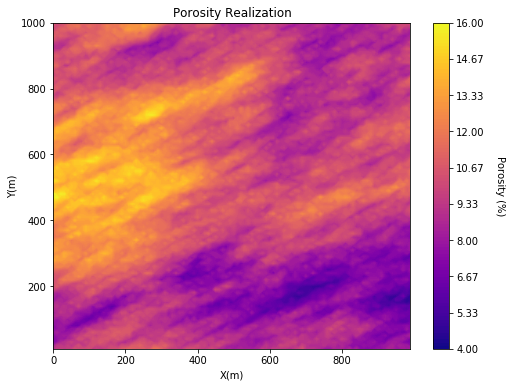

In [13]:
pixelplt(sim,xmin,xmax,ymin,ymax,cell_size,vmin,vmax,"Porosity Realization","X(m)","Y(m)","Porosity (%)",cmap,"Porosity")

Let's extract regular samples from our truth dataset.  These regular samples should provide a somewhat representative sample of the realization.

In [14]:
sampling_ncell = 10                                              # sample every 10th node from the model
samples = regular_sample(sim,xmin,xmax,ymin,ymax,sampling_ncell,10,10,'Realization')

We can visualize the truth model and the samples with locpix.  The parameters of locpix are (array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap).  These are the same as pixelplt with the addition of the locmap parameters described below.

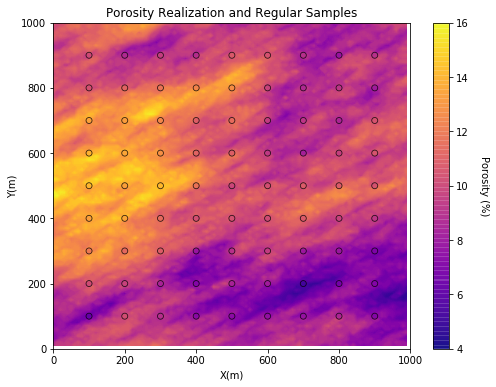

In [16]:
locpix(sim,xmin,xmax,ymin,ymax,cell_size,vmin,vmax,samples,'X','Y','Realization','Porosity Realization and Regular Samples','X(m)','Y(m)','Porosity (%)',cmap,"Por_Samples")

Now let's make this regular sample set *less representative* by selectively removing some of the samples in the low-valued regions.  

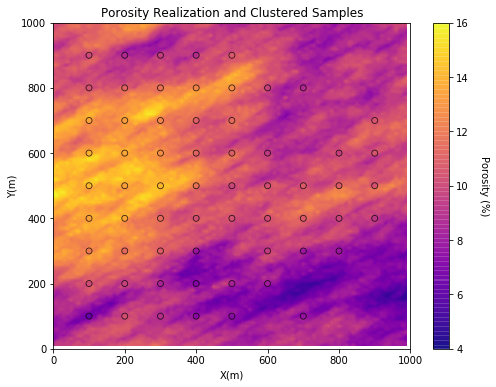

In [18]:
samples_cluster = samples.drop([80,79,78,73,72,71,70,65,64,63,61,57,56,54,53,47,45,42]) # this removes specific rows (samples)
samples_cluster = samples_cluster.reset_index(drop=True)         # we reset and remove the index (it is not sequential anymore)

locpix(sim,xmin,xmax,ymin,ymax,cell_size,vmin,vmax,samples_cluster,'X','Y','Realization','Porosity Realization and Clustered Samples','X(m)','Y(m)','Porosity (%)',cmap,"Porosity_Clustered")

Let's take a look at the samples with out the truth model.  We do this with a location map, locmap as the parameters (df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap), df, xcol, ycol, vcol is a DataFrame and the column names for x, y and feature of interest, xmin, xmax, ymin, ymax, vmin and vmax are the ranges for x, y and the feature of interest, the remainder are labels and the color map.

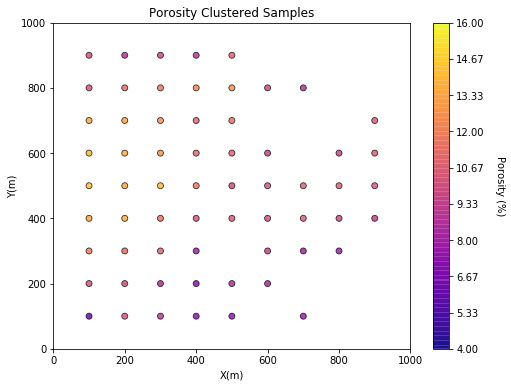

In [20]:
locmap(samples_cluster,'X','Y','Realization',xmin,xmax,ymin,ymax,vmin,vmax,'Porosity Clustered Samples','X(m)','Y(m)','Porosity (%)',cmap,"Porosity_Cluster_Samples")

Let's compare the distribution and means of the truth model and the spatially clustered samples.  We do this with the hist function that is reimplemented from GSLIB's hist method for histogram plotting.  The parameters of hist are (array,xmin,xmax,log,cumul,bins,weights,xlabel,title), including array, xmin and xmax the data array and minimum and maximum of the feature, log and cumul with true for log axis and cumulative distribution function, bins for the number of bins, weights for an array of same size of the data array with weights and the remainder are labels.

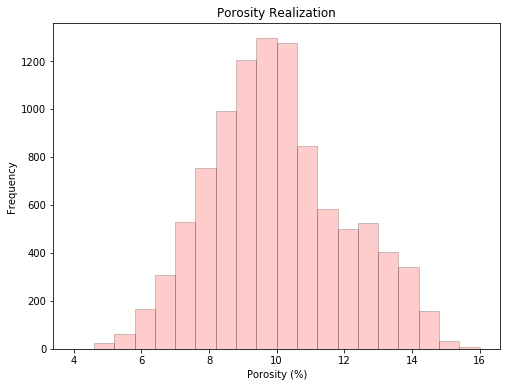

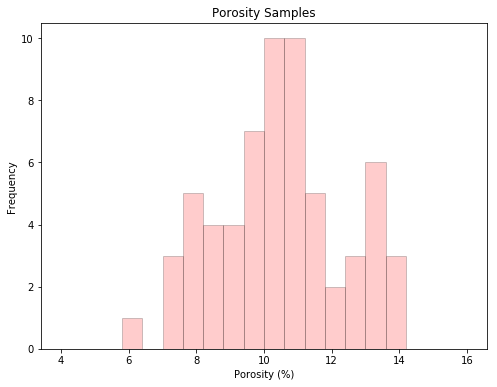

Truth Mean =  10.0 , Clustered Sample Mean =  10.49 , Error =  4.9 %


In [24]:
hist(sim.flatten(),vmin,vmax,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Porosity Realization",fig_name="Porosity_Hist")
hist(samples_cluster["Realization"],vmin,vmax,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (%)",title="Porosity Samples",fig_name="Porosity_Hist_Samples")
sm_mean = np.average(samples_cluster['Realization'])
ex_mean = np.average(sim)
print('Truth Mean = ',round(ex_mean,2),', Clustered Sample Mean = ',round(sm_mean,2),', Error = ',round((sm_mean-ex_mean)/ex_mean,3)*100,'%')

Note the shift in mean from the truth model to the clustered sample. There is a 4.8% inflation in the clustered sample mean! This will be a good demonstration clustered data set for the value of cell-based declustering. We have created a biased sample set with spatial clustering.  Now we can try some declustering. 

Let's apply the wrapper of declus, the GSLIB cell-based declustering program, to this sample set.  The declus method has the following parameters (df,xcol,ycol,vcol,cmin,cmax,cnum,bmin) where df, xcol, ycol, vcol are the DataFrame with the data and the columns with x, y and feature, cmin and cmax are the minimum and maximum cell sizes, cnum is the number of cell sizes (discretization of this range) and bmin is true for selecting the cell size that minimizes the declustered mean (set to false for the cell that maximizes the declustered mean).  

The output from the declus function is a 1D numpy array of weigths with the same size and order as the input DataFrame.  After we calculate the weights numpy array we convert it to a DataFrame and append it (concat) it to our sample DataFrame.  Then we visualize the histogram and location map of the weights.  We will take a wide range of cell sizes from 10m to 500m going from much smaller than the minimum data spacing to half the model extent.

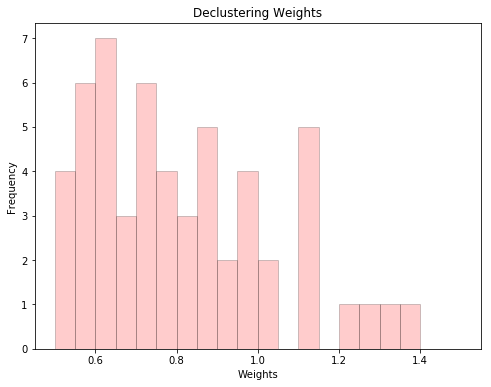

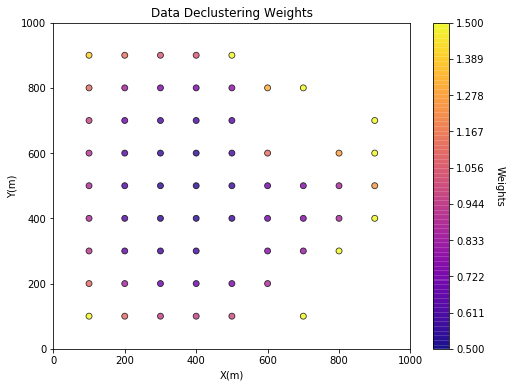

In [25]:
weights = declus(samples_cluster,'X','Y','Realization',cmin=10,cmax=500,cnum=10,bmin=0)
df_wts = pd.DataFrame(weights)
df_wts.columns = ["Weights"]

samples_wts = pd.concat([samples_cluster,df_wts],axis = 1)

hist(weights,0.5,1.5,log=False,cumul=False,bins=20,weights=None,xlabel="Weights",title="Declustering Weights",fig_name="Weights_Hist")
locmap(samples_wts,'X','Y','Weights',xmin,xmax,ymin,ymax,0.5,1.5,'Data Declustering Weights','X(m)','Y(m)','Weights',cmap,"Weights_Locmap")

Now let's see if we made an improvement in our Porosity distribution.  We will plot the declustered distribution and compare the truth, clustered and declustered means. 

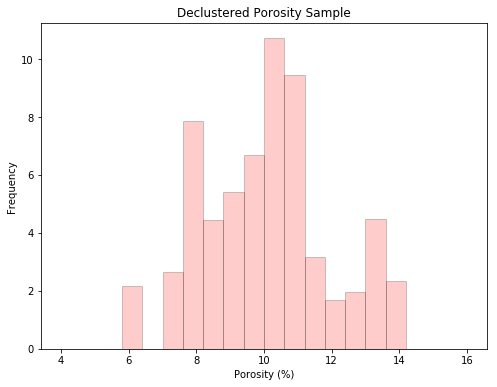

Truth Mean =  10.0 , Clustered Sample Mean =  10.49 , Error =  5.0 %
Declustered Mean =  10.08 , Error =  1.0 %


In [26]:
hist(samples_wts["Realization"],4,16,log=False,cumul=False,bins=20,weights=samples_wts["Weights"],xlabel="Porosity (%)",title="Declustered Porosity Sample",fig_name="Declus_Porosity_Hist")
sm_mean = np.average(samples_cluster['Realization'])
ex_mean = np.average(sim)
de_mean = np.average(samples_wts["Realization"],weights = samples_wts["Weights"])
print('Truth Mean = ',round(ex_mean,2),', Clustered Sample Mean = ',round(sm_mean,2),', Error = ',round((sm_mean-ex_mean)/ex_mean,2)*100,'%')
print('Declustered Mean = ',round(de_mean,2),', Error = ',round((de_mean-ex_mean)/ex_mean,2)*100,'%')

We have made a great imporvement with cell-based declustering.  We went from a bias up of 5.0% to 1.0% by calculating and applying declustering weights.  


There are so many more exercised and tests that one could attempt to gain experience with decison trees. I'll end here for brevity, but I invite you to continue. Consider, on your own apply other data sets or attempting modeling with random forest and boosting.  I hope you found this tutorial useful. I'm always happy to discuss geostatistics, statistical modeling, uncertainty modeling and machine learning,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
On twitter I'm the @GeostatsGuy.
